In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2025-05-11 18:11:45.622744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 18:11:45.651999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 18:11:45.658653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 18:11:45.696612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Charge npy files
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# Charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../../../Facenet Embeddings/Train/X_train.npy'
path_val   = '../../../../../Facenet Embeddings/Val/X_val.npy'
path_test  = '../../../../../Facenet Embeddings/Test/X_test.npy'

X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.where((y_train[:, 2] == 1) | (y_train[:, 3] == 1), 1, 0)
y_train = y_train.reshape(-1, 1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.where((y_val[:, 2] == 1) | (y_val[:, 3] == 1), 1, 0)
y_val = y_val.reshape(-1, 1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.where((y_test[:, 2] == 1) | (y_test[:, 3] == 1), 1, 0)
y_test = y_test.reshape(-1, 1)


X = np.concatenate((X_val, X_test), axis=0)
y = np.concatenate((y_val, y_test), axis=0)

In [4]:
# Divide data in Val and test
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123, stratify=y)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((5481, 5, 128),
 (1721, 5, 128),
 (1722, 5, 128),
 (5481, 1),
 (1721, 1),
 (1722, 1))

In [5]:
# Value counts of y_train, y_val and y_test
print(pd.Series(y_train.flatten()).value_counts())
print(pd.Series(y_val.flatten()).value_counts())
print(pd.Series(y_test.flatten()).value_counts())

1    5233
0     248
Name: count, dtype: int64
1    1587
0     134
Name: count, dtype: int64
1    1588
0     134
Name: count, dtype: int64


In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.ravel()
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 11.050403225806452, 1: 0.5236957768010702}

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Transformer Encoder
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(loss="binary_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

# Create and train the Transformer model
model = build_transformer_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

I0000 00:00:1747005116.104696  204288 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747005117.198973  204288 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747005117.199079  204288 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747005117.202896  204288 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1747005117.202994  204288 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/500


I0000 00:00:1747005121.039283  204404 service.cc:146] XLA service 0x7f52c4005990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747005121.039354  204404 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-05-11 18:12:01.094372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-11 18:12:01.409859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 50/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3274 - loss: 1.0255

I0000 00:00:1747005124.724785  204404 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4256 - loss: 0.9292 - val_accuracy: 0.5276 - val_loss: 0.7397 - learning_rate: 1.0000e-04
Epoch 2/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5871 - loss: 0.7338 - val_accuracy: 0.5102 - val_loss: 0.7706 - learning_rate: 1.0000e-04
Epoch 3/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5987 - loss: 0.6861 - val_accuracy: 0.5898 - val_loss: 0.6719 - learning_rate: 1.0000e-04
Epoch 4/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5961 - loss: 0.7136 - val_accuracy: 0.7083 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 5/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6728 - loss: 0.6507 - val_accuracy: 0.5967 - val_loss: 0.6552 - learning_rate: 1.0000e-04
Epoch 6/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6764 - loss: 0.6016 - val_accuracy: 0.6293 - val_loss: 0.6320 - learning_rate: 1.0000e-04
Epoch 7/500
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6

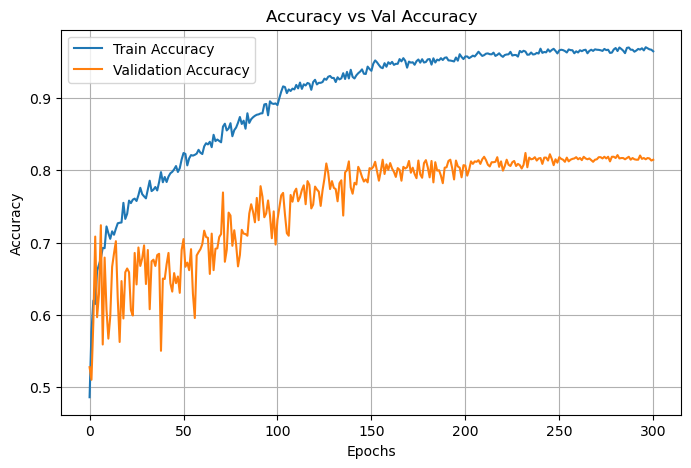

In [8]:
# Train Accuracy vs Val Accuracy 
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

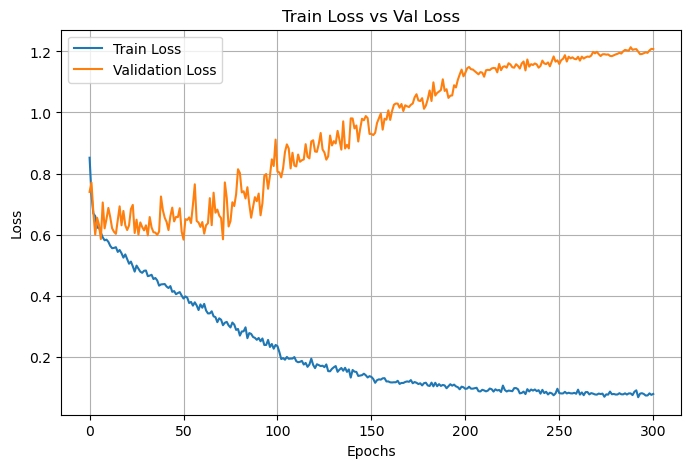

In [9]:
# Train Loss vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Train Loss vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
preds = np.where(preds > 0.5, 1, 0)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


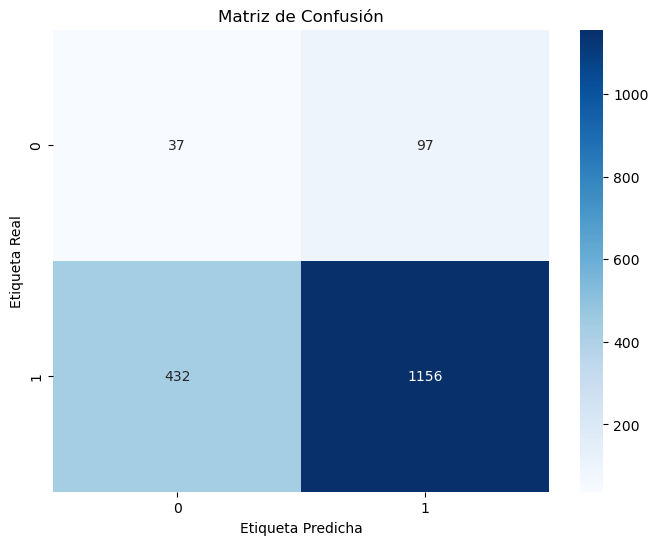

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [13]:
# Classification report
print(classification_report(y_test, preds, digits=3))

              precision    recall  f1-score   support

           0      0.079     0.276     0.123       134
           1      0.923     0.728     0.814      1588

    accuracy                          0.693      1722
   macro avg      0.501     0.502     0.468      1722
weighted avg      0.857     0.693     0.760      1722



In [14]:
# UAR metric
def uar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar_score = uar(y_test, preds)
print(f'UAR: {uar_score:.4f}')

UAR: 0.5020


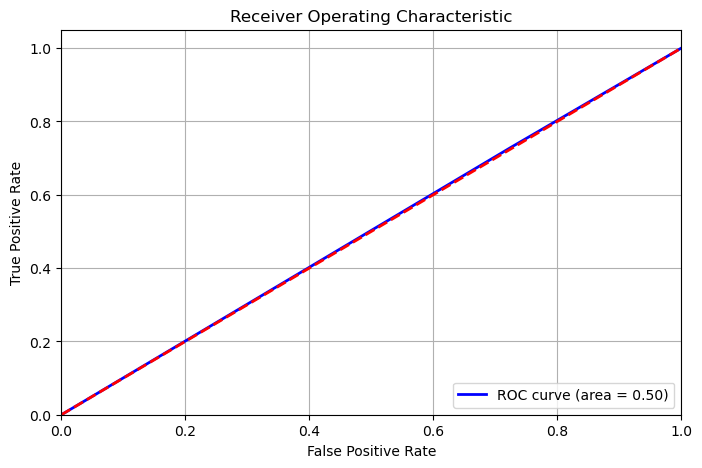

In [15]:
# plot roc curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)

In [16]:
# compute value of roc
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, preds)
print(f'ROC AUC: {roc_auc:.4f}')
plt.show()

ROC AUC: 0.5020


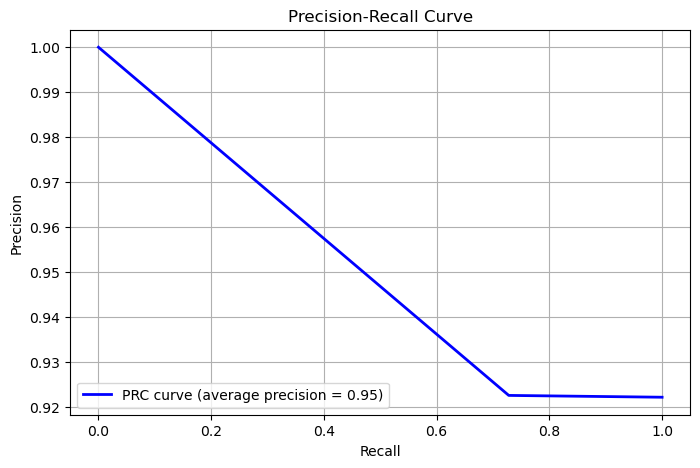

In [17]:
# Plot PRC curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, preds)
average_precision = np.mean(precision)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (average precision = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()